In [1]:
#Importing the packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,MaxPool2D,Conv2D,UpSampling2D,Activation,BatchNormalization,Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import datetime
import pandas as pd

In [3]:
!gdown --id 1C_pHqRMyWfPLsT729v6uK8COoa3aPW26

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1C_pHqRMyWfPLsT729v6uK8COoa3aPW26
To: /content/BSDS500.zip
100% 37.5M/37.5M [00:00<00:00, 50.1MB/s]


In [ ]:
!unzip BSDS500.zip

In [5]:
cd BSDS500

/content/BSDS500


In [6]:
!gdown --id 1QCoUzZw072AZlfRZWNzLXVqGmgMVmzZ6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QCoUzZw072AZlfRZWNzLXVqGmgMVmzZ6
To: /content/BSDS500/patches.zip
100% 159M/159M [00:00<00:00, 328MB/s]


In [ ]:
!unzip patches.zip

In [8]:
#Getting the filepaths for train and test data
train_files=['data/patches/train/'+filename for filename in os.listdir('data/patches/train')]
test_files=['data/patches/test/'+filename for filename in os.listdir('data/patches/test')]

In [ ]:
train_files

In [10]:
def _parse_function(filename):
    '''This function performs adding noise to the image given by Dataset'''
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [11]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50] 

#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)

Shape of single batch of x :  (64, 40, 40, 3)
Shape of single batch of y :  (64, 40, 40, 3)


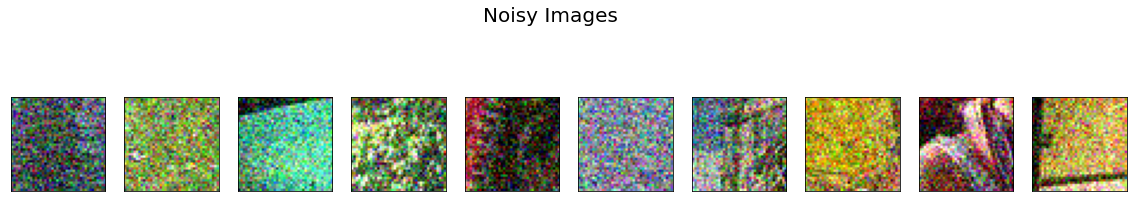

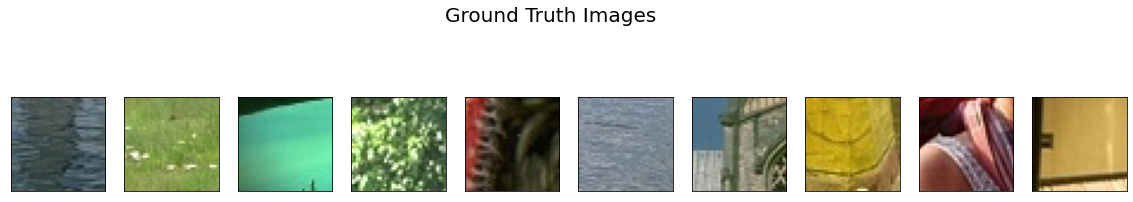

In [13]:
#Plotting the images from dataset to verify the dataset
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(a[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Noisy Images',fontsize=20)
plt.show()
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(b[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Ground Truth Images',fontsize=20)
plt.show()

## Helper Functions

In [14]:
def get_patches(file_name,patch_size,crop_sizes):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)

def predict_fun(model,image_path,noise_level=30):
  #Creating patches for test image
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

## Autoencoder

In [15]:
tf.keras.backend.clear_session()
def AutoEncoder():
  input=Input((40,40,3),name='Input')
  x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same',name='Conv2d_1')(input)
  x=MaxPool2D(name='Maxpool_1')(x)
  x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same',name='Conv2d_2')(x)
  x=MaxPool2D(name='Maxpool_2')(x)
  x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same',name='Conv2d_3')(x)
  x=UpSampling2D(name='Upsample_1')(x)
  x=Conv2D(64,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same',name='Conv2d_4')(x)
  x=UpSampling2D(name='Upsample_2')(x)
  x=Conv2D(3,kernel_size=(3,3),kernel_initializer='he_normal',activation='relu',padding='same',name='Conv2d_5')(x)

  model=Model(input,x)

  return model

In [16]:
autoencoder=AutoEncoder()

In [17]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40, 40, 3)]       0         
                                                                 
 Conv2d_1 (Conv2D)           (None, 40, 40, 64)        1792      
                                                                 
 Maxpool_1 (MaxPooling2D)    (None, 20, 20, 64)        0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 Maxpool_2 (MaxPooling2D)    (None, 10, 10, 64)        0         
                                                                 
 Conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 Upsample_1 (UpSampling2D)   (None, 20, 20, 64)        0     

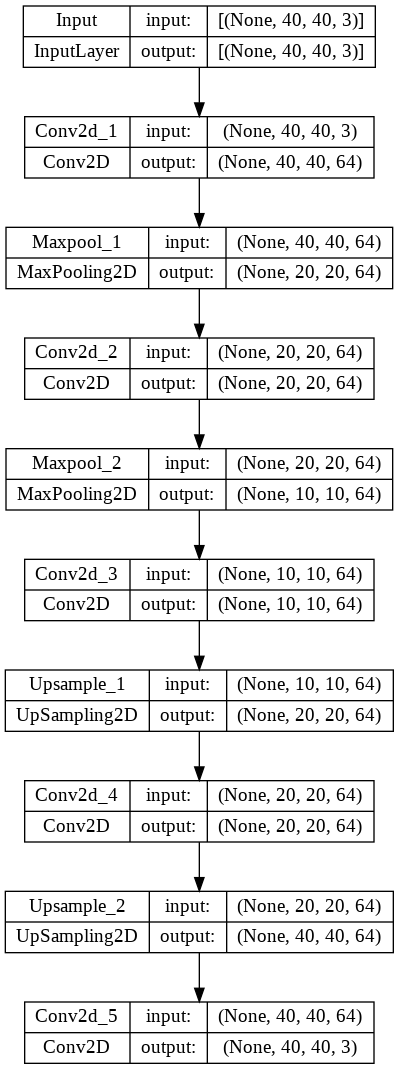

In [19]:
plot_model(autoencoder, 'autoencoder.png', show_shapes=True)

In [23]:
checkpoint_path = "autoencoder.h5" # For each epoch creaking a checkpoint
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) # To save the model if the metric is improved

# Tensorbaord 
! rm -rf ./logs_autoencoder/  # Removing all the files present in the directory
logdir = os.path.join("logs_autoencoder", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Directory for storing the logs that are required for tensorboard
#%reload_ext  tensorboard
#%tensorboard --logdir $logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lrScheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2,verbose=1)

callbacks = [cp_callback,tensorboard_callback,lrScheduler]
autoencoder.fit( train_dataset,shuffle=True,epochs=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 1/10
1338/1338 [==============================] - 61s 38ms/step - loss: 0.0106 - val_loss: 0.0050 - lr: 0.0010
Epoch 2/10
1338/1338 [==============================] - 54s 40ms/step - loss: 0.0048 - val_loss: 0.0043 - lr: 0.0010
Epoch 3/10
1338/1338 [==============================] - 54s 40ms/step - loss: 0.0043 - val_loss: 0.0039 - lr: 0.0010
Epoch 4/10
1338/1338 [==============================] - 55s 41ms/step - loss: 0.0040 - val_loss: 0.0038 - lr: 0.0010
Epoch 5/10
1338/1338 [==============================] - 54s 40ms/step - loss: 0.0038 - val_loss: 0.0036 - lr: 0.0010
Epoch 6/10
1338/1338 [==============================] - 54s 40ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 0.0010
Epoch 7/10
1338/1338 [==============================] - 54s 41ms/step - loss: 0.0035 - val_loss: 0.0035 - lr: 0.0010
Epoch 8/10
1338/1338 [==============================] - 57s 42ms/step - loss: 0.0034 - val_loss: 0.0033 - lr: 0.0010
Epoch 9/10
1338/1338 [==============================] - 53s 40ms

In [24]:
autoencoder.fit( train_dataset,epochs=20,initial_epoch=10,shuffle=True,validation_data= test_dataset,callbacks=callbacks)

Epoch 11/20
1338/1338 [==============================] - 48s 36ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 2.0000e-04
Epoch 12/20
1338/1338 [==============================] - 54s 40ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 2.0000e-04
Epoch 13/20
1337/1338 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1338/1338 [==============================] - 56s 41ms/step - loss: 0.0031 - val_loss: 0.0033 - lr: 2.0000e-04
Epoch 14/20
1338/1338 [==============================] - 52s 39ms/step - loss: 0.0031 - val_loss: 0.0032 - lr: 4.0000e-05
Epoch 15/20
1336/1338 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 15: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
1338/1338 [==============================] - 53s 40ms/step - loss: 0.0031 - val_loss: 0.0032 - lr: 4.0000e-05
Epoch 16/20
1338/1338 [==============================] - 55s 41ms/step - loss: 0.0031 - val_loss: 0

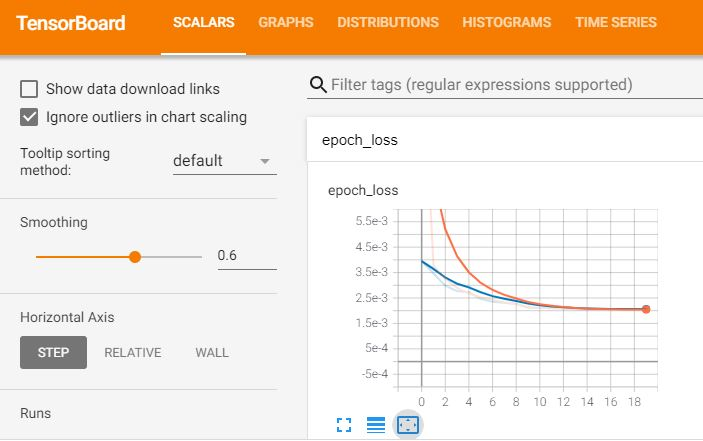

3/3 [==============================] - 0s 4ms/step
PSNR of Noisy Image :  20.513586077846718
PSNR of Denoised Image :  26.881037429737034


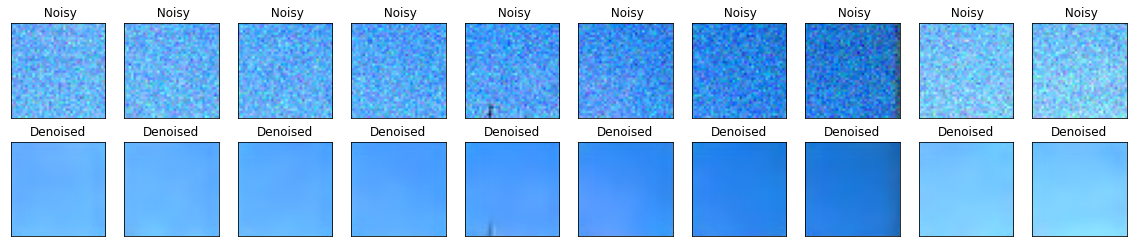

In [25]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(autoencoder,'data/test/102061.jpg',noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

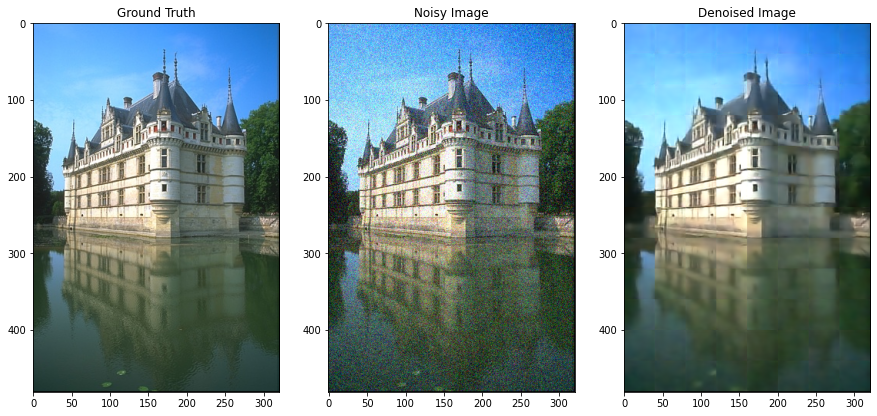

In [26]:
plot_predictions(ground_truth,noisy_image,denoised_image)

cp: cannot stat '/content/autoencoder.h5': No such file or directory


## DnCNN

In [28]:
def DnCNN():
    
    input = Input(shape=(40,40,3),name='input')
    x = Conv2D(64,kernel_size= (3,3), padding='same',name='conv2d_l1')(input)
    x = Activation('relu',name='act_l1')(x)
    for i in range(17):
        x = Conv2D(64, kernel_size=(3,3), padding='same',name='conv2d_'+str(i))(x)
        x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
        x = Activation('relu',name='act_'+str(i))(x)   
    x = Conv2D(3, kernel_size=(3,3), padding='same',name='conv2d_l3')(x)
    x = Subtract(name='subtract')([input, x])   
    model = Model(input,x)
    
    return model

In [29]:
tf.keras.backend.clear_session()
dncnn=None
dncnn=DnCNN()

In [30]:
dncnn.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())

In [31]:
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_l1 (Conv2D)             (None, 40, 40, 64)   1792        ['input[0][0]']                  
                                                                                                  
 act_l1 (Activation)            (None, 40, 40, 64)   0           ['conv2d_l1[0][0]']              
                                                                                                  
 conv2d_0 (Conv2D)              (None, 40, 40, 64)   36928       ['act_l1[0][0]']                 
                                                                                              

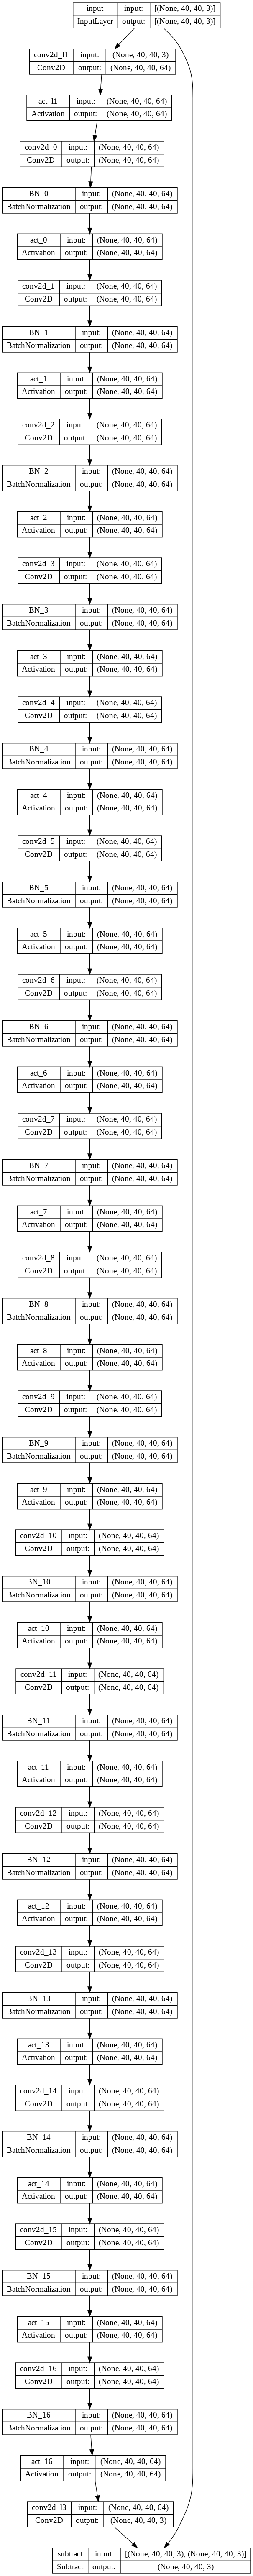

In [37]:
plot_model(dncnn,show_shapes=True,to_file='dncnn.png')

In [33]:
def scheduler(epoch,lr):
  return lr*0.95

In [38]:
checkpoint_path = "dncnn.h5" # For each epoch creaking a checkpoint
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) # To save the model if the metric is improved

# Tensorbaord 
! rm -rf ./logs_dncnn/  # Removing all the files present in the directory
logdir = os.path.join("logs_dncnn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Directory for storing the logs that are required for tensorboard

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [cp_callback,tensorboard_callback,lrScheduler]
dncnn.fit( train_dataset,shuffle=True,epochs=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 1/10
1338/1338 [==============================] - 185s 138ms/step - loss: 0.0028 - val_loss: 0.0063 - lr: 2.7933e-05
Epoch 2/10
1338/1338 [==============================] - 177s 132ms/step - loss: 0.0028 - val_loss: 0.0057 - lr: 2.6537e-05
Epoch 3/10
1338/1338 [==============================] - 176s 132ms/step - loss: 0.0027 - val_loss: 0.0197 - lr: 2.5210e-05
Epoch 4/10
1338/1338 [==============================] - 176s 131ms/step - loss: 0.0027 - val_loss: 0.0041 - lr: 2.3949e-05
Epoch 5/10
1338/1338 [==============================] - 176s 131ms/step - loss: 0.0027 - val_loss: 0.0124 - lr: 2.2752e-05
Epoch 6/10
1338/1338 [==============================] - 175s 131ms/step - loss: 0.0027 - val_loss: 0.0064 - lr: 2.1614e-05
Epoch 7/10
1338/1338 [==============================] - 176s 131ms/step - loss: 0.0027 - val_loss: 0.0139 - lr: 2.0534e-05
Epoch 8/10
1338/1338 [==============================] - 184s 138ms/step - loss: 0.0027 - val_loss: 0.0160 - lr: 1.9507e-05
Epoch 9/10
1338/

In [39]:
dncnn.fit( train_dataset,shuffle=True,epochs=30,initial_epoch=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 11/30
1338/1338 [==============================] - 184s 138ms/step - loss: 0.0027 - val_loss: 0.0099 - lr: 1.6725e-05
Epoch 12/30
1338/1338 [==============================] - 184s 137ms/step - loss: 0.0027 - val_loss: 0.0113 - lr: 1.5889e-05
Epoch 13/30
1338/1338 [==============================] - 184s 137ms/step - loss: 0.0027 - val_loss: 0.0047 - lr: 1.5094e-05
Epoch 14/30
1338/1338 [==============================] - 175s 131ms/step - loss: 0.0026 - val_loss: 0.0041 - lr: 1.4339e-05
Epoch 15/30
1338/1338 [==============================] - 175s 131ms/step - loss: 0.0026 - val_loss: 0.0060 - lr: 1.3622e-05
Epoch 16/30
1338/1338 [==============================] - 184s 138ms/step - loss: 0.0026 - val_loss: 0.0080 - lr: 1.2941e-05
Epoch 17/30
1338/1338 [==============================] - 184s 137ms/step - loss: 0.0026 - val_loss: 0.0075 - lr: 1.2294e-05
Epoch 18/30
1338/1338 [==============================] - 175s 131ms/step - loss: 0.0026 - val_loss: 0.0081 - lr: 1.1680e-05
Epoch 19

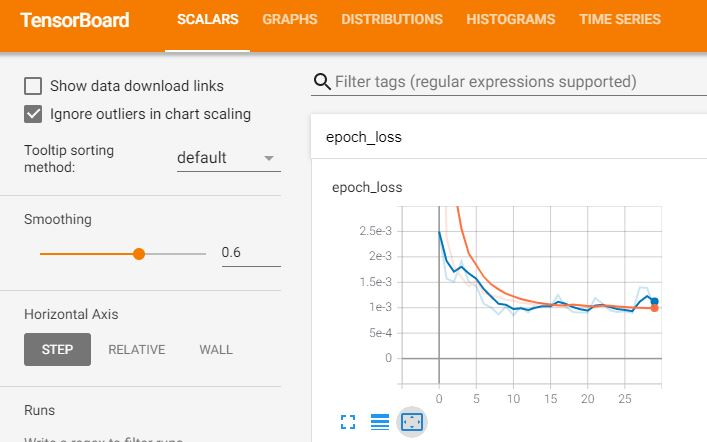

In [40]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

cp: cannot stat '/content/dncnn.h5': No such file or directory


cp: cannot stat '/content/logs_dncnn': No such file or directory


In [52]:
#dncnn=tf.keras.models.load_model('dncnn.h5')

3/3 [==============================] - 0s 29ms/step
PSNR of Noisy Image :  20.525220784223066
PSNR of Denoised Image :  28.096155404647867


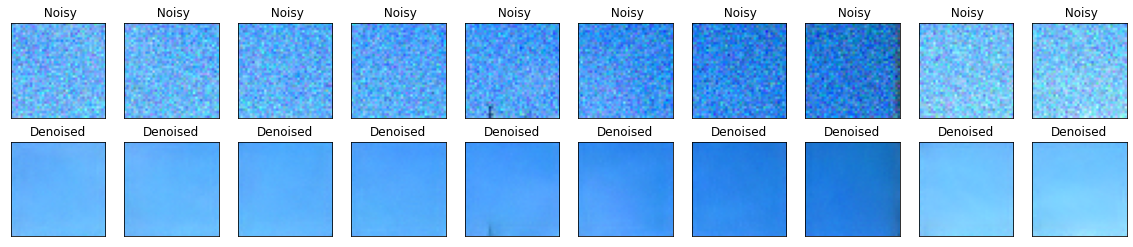

In [44]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'data/test/102061.jpg',noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

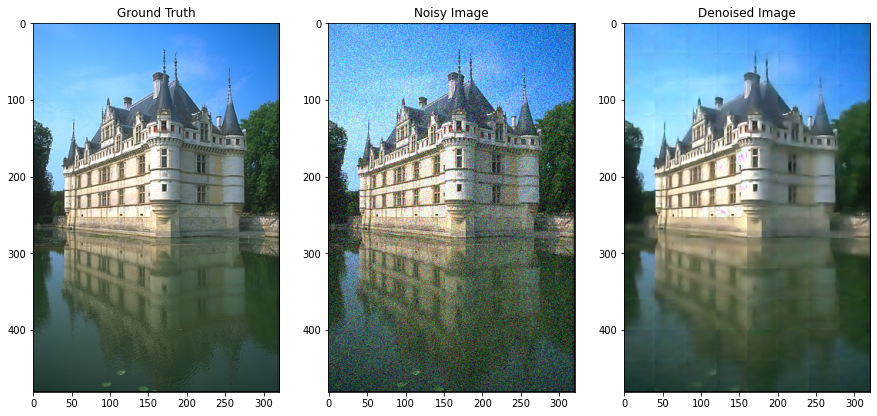

In [45]:
plot_predictions(ground_truth,noisy_image,denoised_image)

## Residual Learning

In [46]:
layer_name = 'conv2d_l3' # Getting the output from the model just before subtract layer, Thus it gives the resiudues learnt
dncnn_res= Model(inputs=dncnn.input, outputs=dncnn.get_layer(layer_name).output) # Creating the model that gives the residual image output for the given noisy image

3/3 [==============================] - 0s 28ms/step


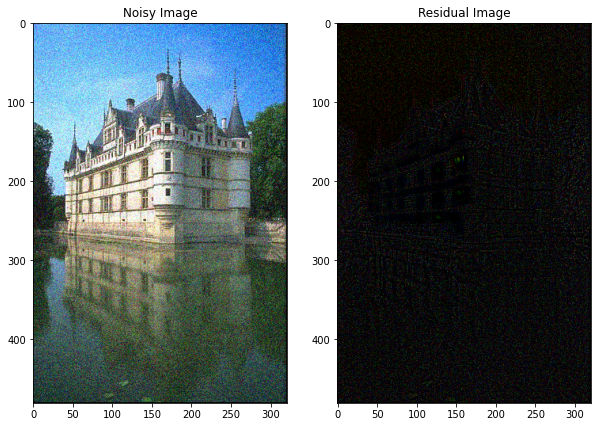

In [47]:
patches_noisy,denoised_patches,ground_truth,noisy_image,residual_image=predict_fun(dncnn_res,'data/test/102061.jpg',noise_level=25)
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(noisy_image)
axs[0].title.set_text('Noisy Image')
axs[1].imshow(residual_image)
axs[1].title.set_text('Residual Image')

<h3><p>We can observe the above residual image that was predicted by the model given noisy image.</p>
<p>Thus given input noisy image 'y' the model predicts residual image 'R' and we can get clean image by doing </p>
<p><b>x=y-R</b></p>
</h3>

## Results

In [48]:
results=pd.DataFrame(columns=['Noise Level','Noise Image','Autoencoder','DnCNN'])

In [49]:
def get_results(results,noise_level):
  patches_noisy_d,denoised_patches_d,ground_truth,noisy_image_d,denoised_image_d=predict_fun(dncnn,'data/test/102061.jpg',noise_level=noise_level)
  patches_noisy_a,denoised_patches_a,ground_truth,noisy_image_a,denoised_image_a=predict_fun(autoencoder,'data/test/102061.jpg',noise_level=noise_level)
  results.loc[len(results.index)]=[noise_level,PSNR(ground_truth,noisy_image_a),PSNR(ground_truth,denoised_image_a),PSNR(ground_truth,denoised_image_d)]

  return results

In [50]:
results=get_results(results,15)
results=get_results(results,20)
results=get_results(results,25)
results=get_results(results,30)
results=get_results(results,40)
results=get_results(results,45)

3/3 [==============================] - 0s 5ms/step


In [51]:
print('Tabulating the model results with different noise level \n')
results.head(6)

Tabulating the model results with different noise level 



Noise Level  Noise Image  Autoencoder      DnCNN
0         15.0    24.856669    26.756477  27.855562
1         20.0    22.394419    26.845566  27.984170
2         25.0    20.515148    26.924867  28.083651
3         30.0    19.008748    26.927621  28.095935
4         40.0    16.726345    26.906481  27.877831
5         45.0    15.817729    26.747442  27.627449